# Titanic Machine Learning Project

### Add Imports

In [96]:
#Imports

#data imports
import pandas as pd
import numpy as np
from scipy.stats import randint

#machine learning imports
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

#visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

#just to hide warnings for certain models
import warnings


### Create the Dataframe

In [97]:
data = pd.read_csv("data/titanic.csv")
data.info()
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


### Fill in missing ages

In [98]:
def fill_missing_ages(df):
    age_fill_map = {}
    for pclass in df["Pclass"].unique():
        if pclass not in age_fill_map:
            age_fill_map[pclass] = df[df["Pclass"] == pclass]["Age"].median()

    df["Age"] = df.apply(lambda row: age_fill_map[row["Pclass"]] if pd.isnull(row["Age"]) else row["Age"], axis=1)


### Data Cleaning and Feature Engineering

In [99]:
def preprocess_data(df):
    # Delete all Columns/data aren't relevant for what we're trying to accomplish
    df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin", "Embarked"], inplace=True)

    #Fill in missing data from Embarked
    # df["Embarked"].fillna("S", inplace=True)
    # df.drop(columns=["Embarked"], inplace=True)
    
    fill_missing_ages(df)

    # Convert Gender to binary for machine learning
    df["Sex"] = df["Sex"].map({"male":0, "female":1})

    # Feature Engineering: Creating new columns in our data to help enhance the model
    df["FamilySize"] = df["SibSp"] + df["Parch"]
    df["IsAlone"] = np.where(df["FamilySize"] == 0, 1, 0)
    df["FareBin"] = pd.qcut(df["Fare"], 4, labels=False)
    df["AgeBin"] = pd.cut(df["Age"], bins=[0,12,20,40,60, np.inf], labels=False)

    return df




### Update and check the Data

In [100]:
data = preprocess_data(data)

# Features for Linear Models (Logistic Regression)
features_linear = ["Pclass", "Sex", "Age", "Fare", "FamilySize", "IsAlone"]

# Features for Tree-Based Models or KNN
features_tree = ["Pclass", "Sex", "AgeBin", "FareBin", "FamilySize", "IsAlone"]

#display(data.head(10))
display(data.sample(10))
#display(data.tail(10))

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,IsAlone,FareBin,AgeBin
688,0,3,0,18.0,0,0,7.7958,0,1,0,1
90,0,3,0,29.0,0,0,8.0500,0,1,1,2
511,0,3,0,24.0,0,0,8.0500,0,1,1,2
425,0,3,0,24.0,0,0,7.2500,0,1,0,2
825,0,3,0,24.0,0,0,6.9500,0,1,0,2
754,1,2,1,48.0,1,2,65.0000,3,0,3,3
109,1,3,1,24.0,1,0,24.1500,1,0,2,2
39,1,3,1,14.0,1,0,11.2417,1,0,1,1
454,0,3,0,24.0,0,0,8.0500,0,1,1,2
126,0,3,0,24.0,0,0,7.7500,0,1,0,2


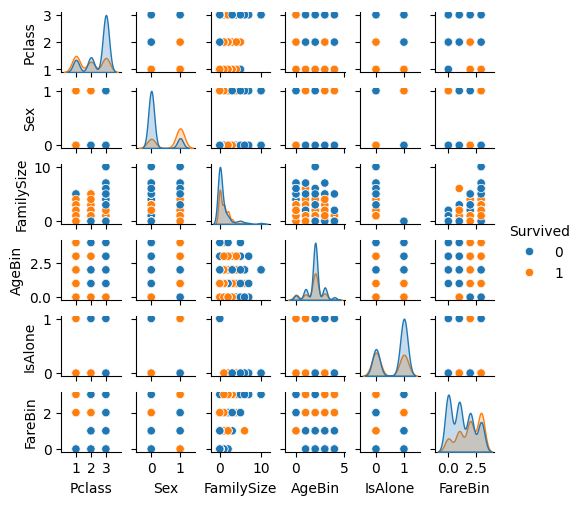

In [101]:
numeric_cols = ["Survived", "Pclass", "Sex", "FamilySize", "AgeBin", "IsAlone", "FareBin"]
sns.pairplot(data[numeric_cols], hue="Survived", height=0.85)

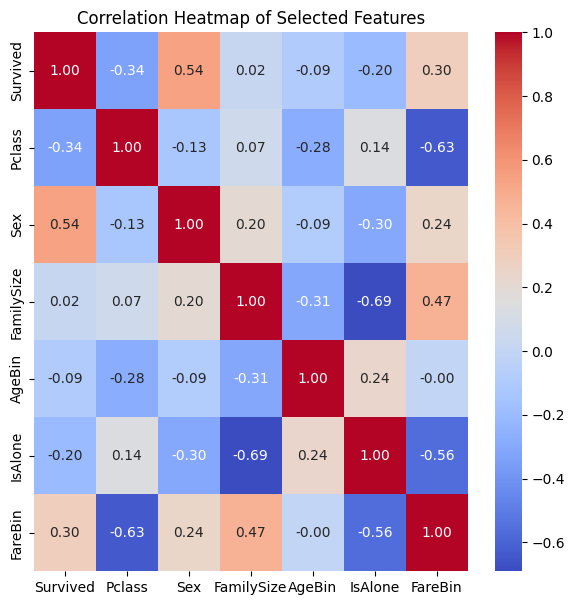

In [102]:
plt.figure(figsize=(7,7))
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Selected Features")
plt.show()

## Create Features / Target Variables (Make Flashcards)
### ML Preprocessing
When we take our data and we make sure it's numerically formatted for the model to understand

In [103]:
# X = data[features_linear]
# y = data["Survived"]
X = data.drop(columns=["Survived"])
y = data["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train_linear = X_train[features_linear]
X_train_tree = X_train[features_tree]
X_test_linear = X_test[features_linear]
X_test_tree = X_test[features_tree]


scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_linear_scaled = scaler.fit_transform(X_train_linear)
X_test_linear_scaled = scaler.transform(X_test_linear)
X_train_tree_scaled = scaler.fit_transform(X_train_tree)
X_test_tree_scaled = scaler.transform(X_test_tree)



# At this point, I have 6 train/test options of inputs I can give to any given model
#    - X_train
#    - X_train_scaled
#    - X_train_linear
#    - X_train_linear_scaled
#    - X_train_tree
#    - X_train_tree_scaled

## Hyperparameter Tuning - KNN

In [104]:
def tune_model(X_train_tree, y_train):
    param_grid = {
        "n_neighbors":range(1,21),
        "metric" : ["euclidean", "manhetten", "minkowski"],
        "weights" : ["uniform", "distance"]
    }

    model = KNeighborsClassifier()
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train_tree, y_train)
    return grid_search.best_estimator_

warnings.filterwarnings("ignore")
best_model = tune_model(X_train_tree, y_train)

## KNN Evaluation and Modeling

In [105]:
def evaluate_model(model, X_test_tree, y_test):
    prediction = model.predict(X_test_tree)
    accuracy = accuracy_score(y_test, prediction)
    matrix = confusion_matrix(y_test, prediction)
    return accuracy, matrix

accuracy, matrix = evaluate_model(best_model, X_test_tree, y_test)

print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Confusion Matrix:')
print(matrix)

Accuracy: 84.30%
Confusion Matrix:
[[119  15]
 [ 20  69]]


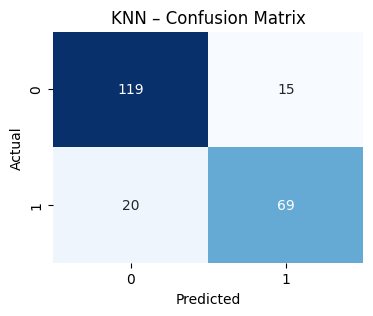

In [106]:
plt.figure(figsize=(4, 3))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("KNN – Confusion Matrix")
plt.show()


## Train & Basic Score for Logistic Regression

In [ ]:
param_grid = {
    "C": [0.01, 0.1, 1, 10, 30, 50],
    "penalty": ["l2"],           # with lbfgs/Saga, l2 only (l1 needs liblinear/saga)
    "solver": ["lbfgs", "liblinear"]          # try "liblinear" for small datasets
}
gs = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), param_grid, cv=10, scoring="roc_auc", n_jobs=-1)
gs.fit(X_train_tree, y_train)

best_logreg = gs.best_estimator_
print("Best params:", gs.best_params_)
print("CV best ROC-AUC:", gs.best_score_)
print("Test ROC-AUC:", roc_auc_score(y_test, best_logreg.predict_proba(X_test_tree)[:,1]))

y_pred = best_logreg.predict(X_test_tree)
accuracy = accuracy_score(y_test, y_pred)
print(f'"Test Accuracy:" {accuracy*100:.2f}%')


Best params: {'C': 30, 'penalty': 'l2', 'solver': 'liblinear'}
CV best ROC-AUC: 0.838950951487537
Test ROC-AUC: 0.8766560456146235
"Test Accuracy:" 80.27%


### Confusion Matrix and ROC Curve for Logistic Regression

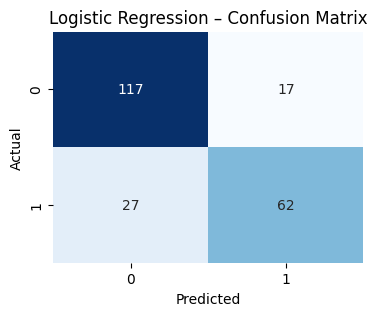

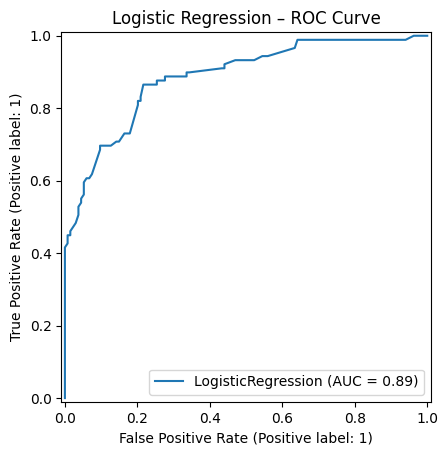

In [108]:
# Predictions
y_pred = best_logreg.predict(X_test_tree)
y_prob = best_logreg.predict_proba(X_test_tree)[:, 1]

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression – Confusion Matrix")
plt.show()

# --- ROC Curve ---

RocCurveDisplay.from_estimator(best_logreg, X_test_tree, y_test)
plt.title("Logistic Regression – ROC Curve")
plt.show()

## Support Vector Machine

In [109]:
# Here will be all the code for the support vector machine

## Random Forest

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42
)
rf.fit(X_train_tree, y_train)

y_train_prob_rf = rf.predict_proba(X_train_tree)[:, 1]

train_auc = roc_auc_score(y_train, y_train_prob_rf)
print("Train ROC-AUC:", train_auc)

y_pred_rf = rf.predict(X_test_tree)
y_prob_rf = rf.predict_proba(X_test_tree)[:, 1]

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
#print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Train ROC-AUC: 0.9259440925758369
Random Forest Accuracy: 0.8385650224215246
Random Forest ROC-AUC: 0.877871876572195


In [128]:
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 4, 6, 8],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=10,
    scoring="roc_auc",
    n_jobs=-1
)

rf_grid.fit(X_train_tree, y_train)

best_rf = rf_grid.best_estimator_

y_train_prob_rf = best_rf.predict_proba(X_train_tree)[:, 1]
train_auc = roc_auc_score(y_train, y_train_prob_rf)
print("Train ROC-AUC:", train_auc)

y_pred_rf = best_rf.predict(X_test_tree)

print("Best Params:", rf_grid.best_params_)
print("Best CV AUC:", rf_grid.best_score_)
print("Test AUC:", roc_auc_score(y_test, best_rf.predict_proba(X_test_tree)[:, 1]))

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
#print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))


Train ROC-AUC: 0.9110195723605885
Best Params: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV AUC: 0.8583479853479854
Test AUC: 0.8855022639610934
Random Forest Accuracy: 0.8251121076233184


### Hyperparameter tuning with GridSearchCV improved the Random Forest’s ROC-AUC, meaning it ranks survivors vs non-survivors more reliably. However, its accuracy at the default 0.5 probability threshold is slightly lower than the simpler baseline Random Forest. This highlights a common trade-off between optimizing for ranking (AUC) and optimizing for a single operating point (accuracy).

## Confusion Matrix and ROC Curve

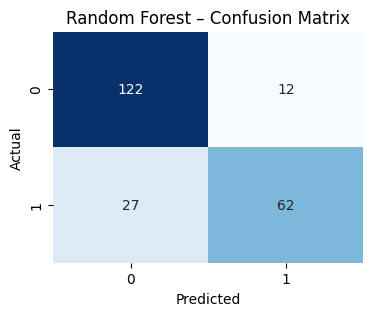

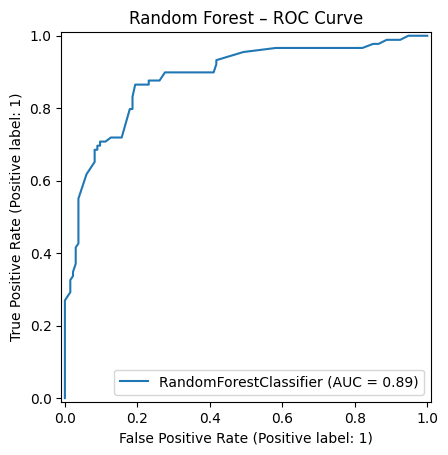

In [129]:
from sklearn.metrics import confusion_matrix, RocCurveDisplay
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Random Forest – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC curve
RocCurveDisplay.from_estimator(best_rf, X_test_tree, y_test)
plt.title("Random Forest – ROC Curve")
plt.show()


## Gradient Boosting

In [136]:
gb = GradientBoostingClassifier(
    n_estimators = 300,
    learning_rate = 0.05,
    max_depth = 3,
    random_state = 42
)

gb.fit(X_train_linear, y_train)

y_pred_gb = gb.predict(X_test_linear)
y_prob_gb = gb.predict_proba(X_test_linear)[:, 1]

print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred_gb))
print("Gradient Boosting ROC-AUC:", roc_auc_score(y_test, y_prob_gb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))

Gradient Boosting Accuracy: 0.820627802690583
Gradient Boosting ROC-AUC: 0.8942646318966962

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.90      0.86       134
           1       0.83      0.70      0.76        89

    accuracy                           0.82       223
   macro avg       0.82      0.80      0.81       223
weighted avg       0.82      0.82      0.82       223



In [ ]:
param_grid_gb = {
    "n_estimators": [100, 200, 400],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.8, 1.0]
}

gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state = 42),
    param_grid_gb,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1
)

gb_grid.fit(X_train_tree, y_train)

best_gb = gb_grid.best_estimator_

print("Best Params:", gb_grid.best_params_)
print("Best CV AUC:", gb_grid.best_score_)

y_pred_gb = best_gb.predict(X_test_tree)
y_prob_gb = best_gb.predict_proba(X_test_tree)[:, 1]

print("Test ROC-AUC:", roc_auc_score(y_test, y_prob_gb))
print("Test Accuracy:", accuracy_score(y_test, y_pred_gb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))

Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best CV AUC: 0.8685216158752658
Test ROC-AUC: 0.8929649505282575
Test Accuracy: 0.8251121076233184

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86       134
           1       0.82      0.72      0.77        89

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.81       223
weighted avg       0.82      0.83      0.82       223



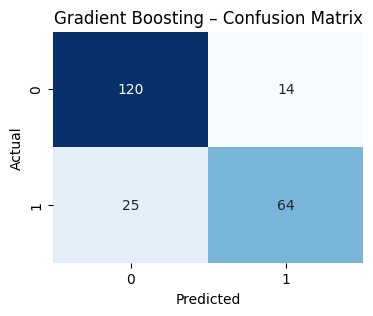

In [ ]:
cm_gb = confusion_matrix(y_test, y_pred_gb)

plt.figure(figsize=(4,3))
sns.heatmap(cm_gb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Gradient Boosting – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()